# DATA 643: Recommender Systems
Final Project:  Book Crossing RecSys | Walt Wells, Summer 2017

# Notebook P3 - Model | Factorization

# Environment Prep

In [1]:
suppressMessages(library(Matrix))
suppressMessages(library(recommenderlab))
suppressMessages(library(ggplot2))
suppressMessages(library(rARPACK))

# Data Prep

In [2]:
BinBook <- readRDS("binBookM.rds")
Book <- readRDS("BookM.rds")

In [3]:
SparseM <- as(Book, "dgCMatrix")

In [4]:
SVDRemoveTable <- function(s) {
    df <- data.frame()
    for (i in seq(nrow(s))) {
        m <- sum(s[1:i, 1:i]^2)/sum(s^2)
        df <- rbind(df, c(i, m))
    }
    names(df) <- c("concepts", "variability")
    df
}

In [5]:
k <- 25
x <- svds(SparseM, k)

In [6]:
str(x)
SMat <- diag(x$d)
U <- x$u
V <- x$v

List of 5
 $ d    : num [1:25] 55.9 49.7 40.7 39.3 38.7 ...
 $ u    : num [1:33095, 1:25] 2.99e-09 -4.79e-19 3.06e-19 -2.99e-20 1.88e-09 ...
 $ v    : num [1:95795, 1:25] 1.01e-08 8.12e-11 -6.64e-15 0.00 5.97e-09 ...
 $ niter: int 6
 $ nops : int 269


In [7]:
mytable <- SVDRemoveTable(SMat)

In [8]:
head(mytable, 10)

concepts,variability
1,0.1051903
2,0.1882037
3,0.2440662
4,0.2959879
5,0.3465185
6,0.3905282
7,0.4333474
8,0.4726216
9,0.5109163
10,0.5485990


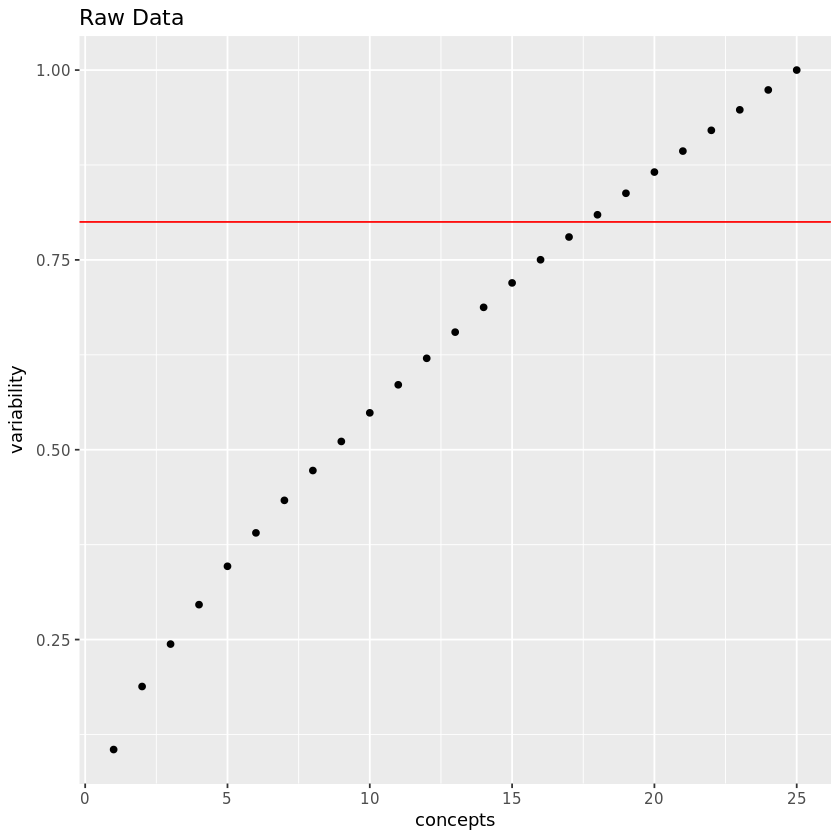

In [9]:
ggplot(mytable, aes(concepts, variability)) + geom_point() + 
    geom_hline(yintercept = .80, color='red') + 
    ggtitle("Raw Data")

In [10]:
n <- .8 * k

NewSMat <- SMat[1:n, 1:n]
NewU <- U[,1:n]
NewV <- V[,1:n]

PreComputed <- NewSMat %*% t(NewV)

In [11]:
print(paste0("Book Ratings as SparseMatrix: ", round(object.size(SparseM)/1024/1024, 3), " MB |  Dim: ", 
             dim(SparseM)[1], ' ', dim(SparseM)[2]))
print(paste0("Book Ratings as S Matrix: ", round(object.size(NewSMat)/1024/1024, 3), " MB |  Dim: ", 
             dim(NewSMat)[1], ' ', dim(NewSMat)[2]))
print(paste0("Book Ratings as U Matrix: ", round(object.size(NewU)/1024/1024, 3), " MB |  Dim: ", 
             dim(NewU)[1], ' ', dim(NewU)[2]))
print(paste0("Book Ratings as V Matrix: ", round(object.size(NewV)/1024/1024, 3), " MB |  Dim: ", 
             dim(NewV)[1], ' ', dim(NewV)[2]))
print(paste0("Book Ratings as S %*% t(V): ", round(object.size(PreComputed)/1024/1024, 3), " MB |  Dim: ", 
             dim(PreComputed)[1], ' ', dim(PreComputed)[2]))

[1] "Book Ratings as SparseMatrix: 20.905 MB |  Dim: 33095 95795"
[1] "Book Ratings as S Matrix: 0.003 MB |  Dim: 20 20"
[1] "Book Ratings as U Matrix: 5.05 MB |  Dim: 33095 20"
[1] "Book Ratings as V Matrix: 14.617 MB |  Dim: 95795 20"
[1] "Book Ratings as S %*% t(V): 14.617 MB |  Dim: 20 95795"


In [12]:
r_bar <- colMeans(Book)
samp <- sample(nrow(NewU),1)
q <- NewU[samp,]
#SampleUserActual <- Book[samp,]

In [13]:
qV <- r_bar + q %*% PreComputed

In [14]:
ItemIndex <- SparseM@Dimnames[2]
qV <- data.frame(ItemIndex, t(qV))
colnames(qV) <- c("ISBN", "Prediction")

In [15]:
n <- 10
sorted_qV <- qV[order(-qV$Prediction), ]
head(sorted_qV, n)

,ISBN,Prediction
86933,3807702628,5.689655
82523,3257017308,5.600000
87308,3894053844,5.500000
87484,3932784863,5.333333
85051,3462029509,5.272727
70685,0964109964,5.250000
95370,9742280142,5.166667
30178,0440403669,5.099731
47972,0671737929,5.058814
21245,0375713042,5.000000


In [16]:
saveRDS(PreComputed, "SVDOutput.rds")